<a href="https://colab.research.google.com/github/sebacoma/Algorithms/blob/main/NarrativeFraming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
n_topic = 10
window_time = None # In days (try: None, 30, 60).
jhu = False

In [2]:
kTotal = 6
kTrans = kTotal / 2
K = 20

In [3]:
from IPython.display import display, HTML
display(HTML("<style>"
    + "#notebook { padding-top:0px !important; } "
    + ".container { width:100% !important; } "
    + ".end_space { min-height:0px !important; } "
    + "</style>"))

In [4]:
!apt-get install -y graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [5]:
!pip install unidecode
!pip install ftfy
!pip install pulp
!pip install umap-learn
!pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.9 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=2abcb2720fadf8aa7cd62f853ff0d56aebe2c9351d5b47b1cd246ef693b3c7e6
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 53.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manyl

In [6]:
# Pandas
import pandas as pd
# Numpy
import numpy as np
from numpy.random import choice
# sklearn
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
# Text preprocessing
from bs4 import BeautifulSoup
from unidecode import unidecode
from ftfy import fix_encoding
# Auxiliary functions
import itertools
from pprint import pprint
#from collections import Counter
from math import floor
import datetime
import gc
import re
import glob
import os
# Import PuLP modeler functions
from pulp import *
# Graphviz
from graphviz import Source, render
# Networkx
import networkx as nx
from math import log, exp
# Topic modeling
import gensim
import gensim.corpora as corpora
from gensim.models import HdpModel
from gensim.utils import simple_preprocess
# Handling dates
from datetime import date
from dateutil.parser import parse
from datetime import datetime

In [7]:
def rchop(thestring, ending):
    if thestring.endswith(ending):
        return thestring[:-len(ending)]
    return thestring

In [8]:
from datetime import datetime, timezone

def utc_to_local(utc_dt):
    return utc_dt.replace(tzinfo=timezone.utc).astimezone(tz=None)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import glob
glob.glob('drive/My Drive/GunControl/GunControl1.1.xlxs')
data = []
path = r'drive/My Drive/GunControl/GunControl1.1.xlsx' # use your path
data = pd.read_excel(path)
#data = pd.concat((pd.read_csv(f, quotechar='"').assign(path=os.path.basename(f)) for f in all_files), sort=True)
data = data.drop(['Q1 Relevant','Q2 Focus','Q3 Theme2','Unnamed: 7','Unnamed: 8','Unnamed: 9','Unnamed: 10','Unnamed: 11','Unnamed: 12'], axis=1)
for index, row in data.iterrows():
    if row['Q3 Theme1'] in [1, 2, 3]:
        data.loc[index, 'Q3 Theme1'] = 1
    elif row['Q3 Theme1'] in [4, 5]:
        data.loc[index, 'Q3 Theme1'] = 2
    elif row['Q3 Theme1'] in [6, 7, 8, 9]:
        data.loc[index, 'Q3 Theme1'] = 3
data

,news_title,Q3 Theme1,Date,Source
0,Inoperable handgun found at Waukegan alternati...,2,2018-01-11,CHICAGO TRIBUNE
1,Cremated remains of Las Vegas mass shooter to ...,3,2018-01-18,LOS ANGELES TIMES
2,7 ways to help prevent school shootings,2,2018-02-07,CNN
3,Cardi B Thinks Black Excellence Scares Trump's...,3,2018-02-12,NEWSWEEK
4,How gun background checks work,1,2018-02-15,CNN
...,...,...,...,...
126,Agriculture candidate Caldwell snags NRA’s fir...,1,2018-06-26,POLITICO
127,The Capital Gazette shooting and the limits of...,1,2018-06-29,VOX
128,Capital Gazette gunman constantly harassed jou...,2,2018-06-29,USA TODAY
129,Teen who allegedly wore white supremacy shirt ...,3,2018-08-06,CHICAGO TRIBUNE


In [11]:
import tensorflow as tf
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embeddings = embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

print(embeddings)

tf.Tensor(
[[-0.03133017 -0.06338634 -0.01607501 ... -0.03242778 -0.0457574
   0.05370456]
 [ 0.0508086  -0.01652434  0.01573779 ...  0.00976657  0.03170121
   0.01788118]], shape=(2, 512), dtype=float32)


In [12]:
import math
from sklearn.metrics.pairwise import cosine_similarity


similarities = np.clip(cosine_similarity(embeddings), -1 , 1)

sim_table = (1 - np.arccos(similarities) / math.pi)
print(np.amax(sim_table))
print(np.amin(sim_table))
sim_table = (sim_table - np.amin(sim_table)) / (np.amax(sim_table) - np.amin(sim_table))
print(sim_table)

1.0
0.50474936
[[0.9996861 0.       ]
 [0.        1.       ]]


In [13]:
embeddings = embed(data['news_title'])
print(embeddings)

tf.Tensor(
[[-0.02080572  0.07098944 -0.07705738 ...  0.03121091  0.0323103
   0.06201537]
 [-0.05061035  0.04503538 -0.07763599 ... -0.03434899  0.02957814
   0.02171722]
 [ 0.05651875  0.00452704 -0.00884992 ...  0.02396126 -0.02826298
   0.02601828]
 ...
 [ 0.03088508 -0.01285863  0.00059719 ...  0.05298059 -0.07410605
  -0.01510425]
 [ 0.0637627   0.04840894 -0.0209571  ... -0.04866866 -0.05451753
   0.00345071]
 [-0.05435711 -0.02615291 -0.06269105 ...  0.03364913 -0.03059533
  -0.06153549]], shape=(131, 512), dtype=float32)


In [14]:
main_array = embeddings.numpy()

In [15]:
data['embedding'] = list(main_array)
data

,news_title,Q3 Theme1,Date,Source,embedding
0,Inoperable handgun found at Waukegan alternati...,2,2018-01-11,CHICAGO TRIBUNE,"[-0.020805722, 0.07098944, -0.07705738, -0.044..."
1,Cremated remains of Las Vegas mass shooter to ...,3,2018-01-18,LOS ANGELES TIMES,"[-0.050610352, 0.04503538, -0.07763599, -0.032..."
2,7 ways to help prevent school shootings,2,2018-02-07,CNN,"[0.056518752, 0.004527045, -0.008849918, -0.08..."
3,Cardi B Thinks Black Excellence Scares Trump's...,3,2018-02-12,NEWSWEEK,"[0.034490332, -0.016249372, -0.04957977, -0.01..."
4,How gun background checks work,1,2018-02-15,CNN,"[-0.04327491, -0.02479683, -0.013964636, -0.00..."
...,...,...,...,...,...
126,Agriculture candidate Caldwell snags NRA’s fir...,1,2018-06-26,POLITICO,"[0.07282063, -0.07003563, -0.020892285, 0.0185..."
127,The Capital Gazette shooting and the limits of...,1,2018-06-29,VOX,"[-0.00489474, -0.0484629, -0.026712194, -0.046..."
128,Capital Gazette gunman constantly harassed jou...,2,2018-06-29,USA TODAY,"[0.030885084, -0.0128586255, 0.00059719116, -0..."
129,Teen who allegedly wore white supremacy shirt ...,3,2018-08-06,CHICAGO TRIBUNE,"[0.0637627, 0.048408937, -0.0209571, -0.036338..."


In [16]:
counter = data.Source.value_counts()
counter

CNN                    19
CHICAGO TRIBUNE        10
THE HILL               10
ABCNEWS                 9
THE NEW YORK TIMES      8
NEWSWEEK                6
WASHINGTON POST         6
NBCNEWS                 6
HUFFPOST                5
POLITICO                4
LOS ANGELES TIMES       4
SLATE                   4
USA TODAY               4
THEBLAZE                4
WALL STREET JOURNAL     3
REUTERS                 3
FRANCE24                3
APNEWS                  2
THE INDEPENDENT         2
YAHOO                   1
THE WEEK                1
RAPPLER                 1
THE CUT                 1
BLOOMBERG               1
THE GUARDIAN            1
CBS NEWS                1
VOX                     1
CHANNELSTV              1
THE SEATTLE TIMES       1
RFI                     1
BLAZE                   1
GQ                      1
DEADLINE                1
PEOPLE                  1
EVENING STANDARD        1
PBS                     1
Name: Source, dtype: int64

In [17]:
data.Source.nunique()

36

In [18]:
query = data
query['news_title'] = query['news_title'].map(lambda a: fix_encoding(a))
query['news_title'] = query['news_title'].map(lambda a: a.replace("’", "'").replace("‘", "'"))
for index, article in query.iterrows():
     title = fix_encoding(query.loc[index,'news_title'])
     query.loc[index,'news_title'] = title


In [19]:
pd.set_option('display.max_rows', 150)
len(query)

131

In [20]:
# start = 4 #1-1#
# end = 127
# start = 4 #1-2#
# end = 128
# start = 4 #1-3#
# end = 130
# start = 0 #2-1#
# end = 127
start = 0 #2-2#
end = 128
# start = 0 #2-3#
# end = 130
# start = 1  #3-1#
# end = 127
# start = 1  #3-3#
# end = 128
# start = 1  #3-3#
# end = 130

In [21]:
print(len(query))
print((start,end))
query = query[start:(end+1)]
print(len(query))
print(query.iloc[0]['news_title'])
print(query.iloc[len(query)-1]['news_title'])
query.head()

131
(0, 128)
129
Inoperable handgun found at Waukegan alternative school
Capital Gazette gunman constantly harassed journalists on Twitter. Why wasn't he stopped?


,news_title,Q3 Theme1,Date,Source,embedding
0,Inoperable handgun found at Waukegan alternati...,2,2018-01-11,CHICAGO TRIBUNE,"[-0.020805722, 0.07098944, -0.07705738, -0.044..."
1,Cremated remains of Las Vegas mass shooter to ...,3,2018-01-18,LOS ANGELES TIMES,"[-0.050610352, 0.04503538, -0.07763599, -0.032..."
2,7 ways to help prevent school shootings,2,2018-02-07,CNN,"[0.056518752, 0.004527045, -0.008849918, -0.08..."
3,Cardi B Thinks Black Excellence Scares Trump's...,3,2018-02-12,NEWSWEEK,"[0.034490332, -0.016249372, -0.04957977, -0.01..."
4,How gun background checks work,1,2018-02-15,CNN,"[-0.04327491, -0.02479683, -0.013964636, -0.00..."


In [22]:
doc_list = []
for index, article in query.iterrows():
    full_text = article.news_title# + " " + article.text
    doc_list.append(article.embedding)


In [23]:
import math
from sklearn.metrics.pairwise import cosine_similarity

similarities = np.clip(cosine_similarity(doc_list), -1 , 1)

sim_table = (1 - np.arccos(similarities) / math.pi)
print(np.amax(sim_table))
print(np.amin(sim_table))
sim_table = (sim_table - np.amin(sim_table)) / (np.amax(sim_table) - np.amin(sim_table))
print(sim_table)

1.0
0.47959965
[[1.         0.2003017  0.30198264 ... 0.09477785 0.19810113 0.06440149]
 [0.2003017  1.         0.12139605 ... 0.08541154 0.15762222 0.14585318]
 [0.30198264 0.12139605 0.9997888  ... 0.04852472 0.18471369 0.13188928]
 ...
 [0.09477785 0.08541154 0.04852472 ... 1.         0.13511015 0.05686616]
 [0.19810113 0.15762222 0.18471369 ... 0.13511015 0.99970126 0.25565943]
 [0.06440149 0.14585318 0.13188928 ... 0.05686616 0.25565943 1.        ]]


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


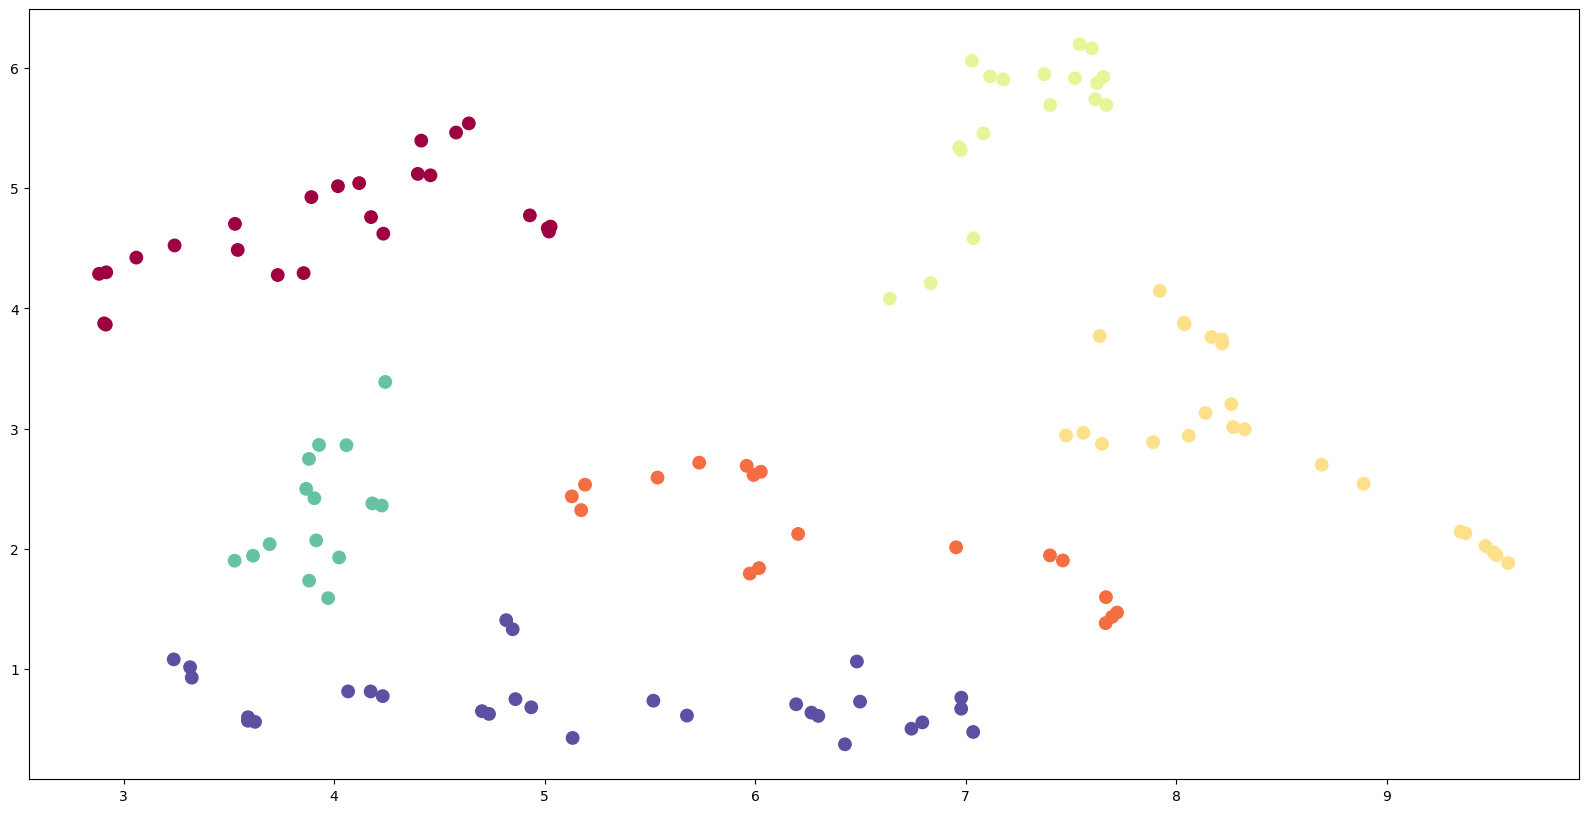

In [24]:
import matplotlib.pyplot as plt
import umap
import hdbscan
import sklearn.cluster as cluster

clusterable_embedding = umap.UMAP(
    n_neighbors=4,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(doc_list)

plt.rcParams["figure.figsize"] = (20,10)

min_samples = 2
min_cluster_size = 10
hdbscan_model = hdbscan.HDBSCAN(
    min_samples=min_samples,
    min_cluster_size=min_cluster_size,
    prediction_data = True
)

labels = hdbscan_model.fit_predict(clusterable_embedding)

clustered = (labels >= 0)
np.sum(clustered) / len(doc_list)

plt.scatter(clusterable_embedding[clustered, 0],
            clusterable_embedding[clustered, 1],
            c=labels[clustered],
            s=80.0,
            cmap='Spectral');

In [25]:
membership_vectors = hdbscan.prediction.all_points_membership_vectors(hdbscan_model)
numclust = membership_vectors.shape[1]
print(numclust)
print(membership_vectors.max(axis = 1))

6
[0.59682477 1.         1.         0.37266396 1.         1.
 1.         1.         1.         1.         1.         0.25175576
 1.         1.         1.         1.         1.         1.
 0.43203279 1.         1.         1.         1.         1.
 0.34864407 0.08288334 1.         1.         1.         0.3910134
 1.         1.         1.         1.         1.         1.
 1.         1.         0.64704677 1.         0.79796202 0.46492192
 0.28451244 0.58453655 0.34092758 0.09852698 1.         1.
 0.34668744 0.73029174 1.         0.23872106 1.         1.
 1.         0.23984034 1.         1.         0.36221463 1.
 1.         1.         0.81106306 1.         0.20559182 0.20426169
 0.20992433 1.         1.         1.         1.         0.22744241
 1.         0.08124306 0.54890509 0.53473947 1.         0.38618948
 0.52085807 0.53573626 0.41376178 0.24583825 1.         1.
 1.         1.         1.         1.         1.         0.24653029
 0.4605683  0.39278233 1.         1.         1.         1.

In [26]:
from scipy.spatial import distance


clust_sim = distance.cdist(membership_vectors, membership_vectors, 'jensenshannon')

clust_sim_table = 1 - clust_sim
print(clust_sim_table)
print(membership_vectors.shape)

[[1.         0.3402046  0.21915428 ... 0.53110397 0.55051366 0.53923329]
 [0.3402046  1.         0.16744539 ... 0.29981915 0.32455825 0.32564249]
 [0.21915428 0.16744539 1.         ... 0.46027758 0.43278874 0.3572578 ]
 ...
 [0.53110397 0.29981915 0.46027758 ... 1.         0.94875842 0.74809566]
 [0.55051366 0.32455825 0.43278874 ... 0.94875842 1.         0.78229105]
 [0.53923329 0.32564249 0.3572578  ... 0.74809566 0.78229105 1.        ]]
(129, 6)


In [27]:
import math

def create_LP(query, sim_table, membership_vectors, clust_sim_table, numclust, K, mincover):
    print("Initializing variable lists...")
    n = len(query) #We can cut out everything after the end.
    # Variable names and indices
    var_i = []
    var_ij = []
    var_k = [str(k) for k in range(0,numclust)]

    for i in range(0, n): # This goes up from 0 to n-1.
        var_i.append(str(i))
        for j in range(i + 1, n):
            var_ij.append(str(i) + "_" + str(j))

    print("Declaring linear program...")
    # Linear program variable declaration.
    minedge = LpVariable("minedge")
    node_act_vars = LpVariable.dicts("node_act", var_i, lowBound = 0, upBound = 1)
    node_next_vars = LpVariable.dicts("node_next", var_ij, lowBound = 0,  upBound = 1)
    clust_active_vars = LpVariable.dicts("clust_active", var_k, lowBound = 0, upBound = 1)

    # Create the 'prob' variable to contain the problem data
    prob = LpProblem("StoryChainProblem", LpMaximize)
    # The objective function is added to 'prob' first
    prob += minedge, "WeakestLink"

    print("Declaring order restrictions...")
    # Chronological
    for i in range(0, n):
        for j in range(i + 1, n):
            if query.iloc[i]['Date'] == query.iloc[j]['Date']:
                prob += node_next_vars[str(i)+"_"+str(j)] == 0, 'Chronological' + str(i) + "_" + str(j)

    # Chain restrictions
    print("Declaring chain restrictions...")
    prob += node_act_vars[str(0)] == 1, 'InitialNode'
    prob += node_act_vars[str(n - 1)] == 1, 'FinalNode'
    prob += lpSum([node_act_vars[i] for i in var_i]) == K, 'KNodes'
    prob += lpSum([node_next_vars[ij] for ij in var_ij]) == K - 1, 'K-1Edges'
    for j in range(1, n):
        prob += lpSum([node_next_vars[str(i) + "_" + str(j)] for i in window_j_i[j]]) == node_act_vars[str(j)], 'InEdgeReq' + str(j)
    for i in range(0, n - 1):
        prob += lpSum([node_next_vars[str(i) + "_" + str(j)] for j in window_i_j[i]]) == node_act_vars[str(i)], 'OutEdgeReq'  + str(i)
    for i in range(0, n - 2):
        for j in range(i + 2, n):
            for k in range(i + 1, j):
                prob += node_next_vars[str(i) + "_" + str(j)] <= 1 - node_act_vars[str(k)], 'NoSkippingTrans'  + str(i) + "_" + str(j) + "_" + str(k)

    # Coverage
    prob += lpSum([clust_active_vars[str(k)] for k in var_k]) >= numclust * mincover, "MinCover"
    for k in range(0, numclust):
        prob += clust_active_vars[str(k)] == lpSum([node_next_vars[str(i) + "_" + str(j)] * math.sqrt(membership_vectors[i, k] * membership_vectors[j, k]) for i in range(0, n - 1) for j in range(i + 1, n)]), "CoverDef" + str(k)
        #prob += clust_active_vars[str(k)] == lpSum([node_act_vars[str(i)] * membership_vectors[i, k] for i in range(0, n)])
        #prob += clust_active_vars[str(k)] == (1 / sum(membership_vectors[:, k])) * lpSum([node_act_vars[str(i)] * membership_vectors[i, k] for i in range(0, n)])

    # Objective
    print("Declaring objective restrictions...")
    for i in range(0, n):
        for j in range(i + 1, n):
            prob += minedge <= 1 - node_next_vars[str(i) + "_" + str(j)] + math.sqrt(sim_table[i, j] * clust_sim_table[i, j]), "Objective" + str(i) + "_" + str(j)

    print("Linear program initialized correctly.")
    # The problem data is written to an .lp file
    return prob

In [28]:
window_i_j = {}
window_j_i = {}
n = len(query)

if window_time is None:
    for i in range(0, n):
        window_i_j[i] = range(i + 1, n)
    for j in range(1, n):
        window_j_i[j] = range(0, j)
else:
    for j in range(1, n):
        window_j_i[j] = []
    for i in range(0, n):
        window_i_j[i] = []
    for i in range(0, n - 1):
        window = 0
        for j in range(i + 1, n):
            #print(query.iloc[j]['Date'])
            delta = datetime.strptime(query.iloc[j]['Date'], '%Y-%m-%d')  - datetime.strptime(query.iloc[i]['Date'], '%Y-%m-%d')
            if delta.days <= window_time:
                window += 1
            window = max(min(5, n - i), window)
            window_i_j[i] = range(i + 1, min(i + window, n))
        for j in window_i_j[i]:
            #print(window_i_j[i])
            window_j_i[j].append(i)

In [29]:
cred = {'default': 1.0}
pol_orientation = {'default': 'default'}

# Create LP
prob_left = create_LP(query, sim_table, membership_vectors, clust_sim_table, numclust, K=6, mincover=0.5)
# Write LP
print("Writing LP...")
prob_left.writeLP("left_story.lp")
# Solve LP with PuLP
print("Solving LP...")
prob_left.solve()
print("Solved LP.")
print("Status:", LpStatus[prob_left.status])

Initializing variable lists...
Declaring linear program...
Declaring order restrictions...
Declaring chain restrictions...
Declaring objective restrictions...
Linear program initialized correctly.
Writing LP...
Solving LP...
Solved LP.
Status: Optimal


In [30]:
clust_active_list = []
for v in prob_left.variables():
    if "clust_active" in v.name:
        clust_active_list.append(v.varValue)
        print(v.name, "=", v.varValue)
print(sum(clust_active_list))
print(sum(clust_active_list) / numclust)

clust_active_0 = 0.27130464
clust_active_1 = 0.4419148
clust_active_2 = 0.71600327
clust_active_3 = 0.1756244
clust_active_4 = 0.46977991
clust_active_5 = 0.92537298
3.0
0.5


In [31]:
def extract_varsdict(prob):
    # We get all the node_next variables in a dict.
    varsdict = {}
    for v in prob.variables():
        if "node_next" in v.name:
            varsdict[v.name] = v.varValue
    return varsdict

varsdict_left = extract_varsdict(prob_left)

In [32]:
from urllib.parse import urlparse
def build_graph_df(query, varsdict, prune, threshold=0.0):
    n = len(query)
    start = 0
    end = n - 1
    graph_df = pd.DataFrame(columns=['index', 'adj_list', 'adj_weights', 'Date', 'publication',
                                     'title', 'text', 'url', 'claims', 'who', 'what', 'where', 'when', 'Q3 Theme1'])

    stack = [start]
    while stack:
        i = stack.pop()
        prob = []
        for j in window_i_j[i]:
            name = "node_next_" + str(i) + "_" + str(j)
            prob.append(varsdict[name])
        idx_list = [idx + i + 1 for idx, e in enumerate(prob) if round(e,8) != 0 and e >= threshold]
        nz_prob = [e for idx, e in enumerate(prob) if round(e,8) != 0 and e >= threshold]
        if prune:
            if len(idx_list) > prune:
                top_prob_idx = sorted(range(len(nz_prob)), key=lambda k: nz_prob[k])[-prune:]
                idx_list = [idx_list[j] for j in top_prob_idx]
                nz_prob = [nz_prob[idx] for idx in top_prob_idx]
        sum_nz = sum(nz_prob)
        #print(i, nz_prob, len(nz_prob), sum_nz)
        nz_prob = [nz_prob[j] / sum_nz for j in range(0, len(nz_prob))]
        for idx in idx_list:
            if idx not in stack and not (graph_df['index'] == idx).any():
                stack.append(idx)
        # If we haven't checked this one before we add it to the graph.
       # url = urlparse(query.iloc[i]['url']).netloc
        url = ""
        if not (graph_df['index'] == i).any():
            graph_df.loc[len(graph_df)] = [i, idx_list, nz_prob, query.iloc[i]['Date'], query.iloc[i]['Source'],
                                           query.iloc[i]['news_title'], '', "", [], '', '', '', '', query.iloc[i]['Q3 Theme1']]

    return graph_df

In [33]:
import ast

In [34]:
def build_graph(graph_df):
    G = nx.DiGraph()
    for index, row in graph_df.iterrows():
        G.add_node(row['index'])
        for idx, adj in enumerate(row['adj_list']):
            G.add_edge(row['index'], adj, weight=max(-log(row['adj_weights'][idx]),0))
    return G

In [35]:
pd.set_option('display.max_rows', 500)
prune = None
print("-")
print(prune)
print("-")
left_graph_df = build_graph_df(query, varsdict_left, prune)

-
None
-


In [36]:
print("Left graph.")
G_l = build_graph(left_graph_df)
start = 0
end = len(query) - 1
print("Sanity check - is it a DAG? " + str(nx.is_directed_acyclic_graph(G_l)))
sp_l = nx.shortest_path(G_l, start, end, weight='weight')
lsp_l = nx.shortest_path_length(G_l, start, end, weight='weight')
print("Shortest path: " + str(sp_l))
print("Negative Log-Likelihood: " + str(lsp_l))
print("Joint Probability: " + str(exp(-lsp_l)))

Left graph.
Sanity check - is it a DAG? True
Shortest path: [0, 18, 34, 128]
Negative Log-Likelihood: 1.7102226286769275
Joint Probability: 0.18082553118685105


In [37]:
end_idx = left_graph_df['index'][left_graph_df['adj_list'].str.len() == 0].tolist()[0]

In [38]:
left_graph_df = left_graph_df.fillna('')
left_graph_df

,index,adj_list,adj_weights,Date,publication,title,text,url,claims,who,what,where,when,Q3 Theme1
0,0,"[3, 9, 18, 23, 80, 122]","[0.2603671297396329, 0.2229398297770602, 0.345...",2018-01-11,CHICAGO TRIBUNE,Inoperable handgun found at Waukegan alternati...,,,[],,,,,2
1,122,[128],[1.0],2018-06-13,CNN,New Jersey is one of the latest states to enac...,,,[],,,,,1
2,128,[],[],2018-06-29,USA TODAY,Capital Gazette gunman constantly harassed jou...,,,[],,,,,2
3,80,[81],[1.0],2018-04-01,THE HILL,Democrat: A gun ban is not 'feasible right now',,,[],,,,,1
4,81,"[83, 85]","[0.509814270002846, 0.49018572999715404]",2018-04-03,CHICAGO TRIBUNE,"ShotSpotter, a gunshot detection system, goes ...",,,[],,,,,2
5,85,"[87, 125]","[0.08583752616643345, 0.9141624738335665]",2018-04-15,THE INDEPENDENT,Man accused of shooting at black teenager who ...,,,[],,,,,3
6,125,[128],[1.0],2018-06-26,LOS ANGELES TIMES,Trump's 'Angel Families' weaponize their grief...,,,[],,,,,1
7,87,[88],[1.0],2018-04-20,CHICAGO TRIBUNE,22 West Aurora students participate in third n...,,,[],,,,,3
8,88,[128],[1.0],2018-04-22,CNN,Nashville mayor demands stricter gun control a...,,,[],,,,,1
9,83,"[87, 89]","[0.8332719706869017, 0.16672802931309824]",2018-04-11,ABCNEWS,National School Walkout: Everything to know ab...,,,[],,,,,3


In [39]:
def is_path_edge(i, j, val_list):
    k = 0
    while val_list[k] <= i:
        if val_list[k] == i and val_list[k+1] == j:
            return True
        k += 1
    return False

In [40]:
def trunc(s, l=70):
    t = s[:l] + '..' if len(s) > l + 2 else s
    return t

In [41]:
import pandas as pd
import ast
query_str = "example"
maps = [query_str]
graph_df_list = {}
G_list = {}
sp_list = {}
centrality_list = {}
start = 0
end = {query_str: end_idx} # Depends on query.

graph_df_list[query_str] = left_graph_df
G_list[query_str] =  build_graph(graph_df_list[query_str])
sp_list[query_str] = nx.shortest_path(G_list[query_str], start, end[query_str], weight='weight')
centrality = nx.betweenness_centrality(G_list[query_str], weight='weight', normalized=False)
centrality = {k: v for k, v in sorted(centrality.items(), key=lambda item: item[1])}
del centrality[start]
del centrality[end[query_str]]
centrality_list[query_str] = centrality

cred = {'default': 1.0}
pol_orientation = {'default': 'default'}

In [42]:
import textwrap

In [43]:
def insert_new_lines(string, every=40):
    mod_string = textwrap.fill(string, every).replace("\n","<br/>")
    return mod_string

def get_publication_img(publication):
    if 'cnn' in publication:
        return "cnn.svg"
    elif 'bbc' in publication:
        return "bbc.svg"
    elif 'aljazeera' in publication:
        return "ajz.svg"
    elif 'guardian' in publication:
        return "tgn.svg"
    elif 'nyt' in publication:
        return "nyt.svg"
    else:
        return 'landmark.svg'

PATH_IMG = "/content/drive/My Drive/img/"

## TODO: Fix single quotes!!! See replace.
def graph_viz_gen(graph_df, sp, narrative_map, antichains=None):
    col_pol = {'default': "#FFFFFF"}
    transparency = "60" #80 is 50%\
    #30, 0.75, 0.50 for January
    #40, 0.50, 0.50 for February
    graph_viz = "digraph " + query_str.capitalize() + " { newrank=true; \n"
    graph_viz += "graph [fontname = \"sans-serif\", ranksep=\"0.75\", nodesep=\"0.25\"];\n"
    graph_viz += "node [shape=plaintext, margin=0, fontname = \"candara\"];\n"
    graph_viz += "edge [fontname = \"candara\"];\n"
    for index, row in graph_df.iterrows():
        if row['index'] in antichains:
            if row['index'] == end[narrative_map] or row['index'] == start:
                node_label = '<table BORDER="0" CELLSPACING="0" BGCOLOR="#85b5a080"><tr><td PORT="0">' \
                + '<IMG SCALE="TRUE" SRC="' + PATH_IMG + get_publication_img(row['publication']) + '"/>' \
                + '</td><td><b>' + insert_new_lines(pd.to_datetime(str(row['Date'])).strftime("%m/%d/%Y") + ' - ' + row['title'].replace("\"", "'").replace("'","")) + " (" + str(row['Q3 Theme1']) + ")" + '</b></td></tr></table>'
            else:
                node_label = '<table BORDER="0" CELLSPACING="0" BGCOLOR="#85b5a080"><tr><td PORT="0">' \
                + '<IMG SCALE="TRUE" SRC="' + PATH_IMG + get_publication_img(row['publication']) + '"/>' \
                + '</td><td>' + insert_new_lines(pd.to_datetime(str(row['Date'])).strftime("%m/%d/%Y") + ' - ' + row['title'].replace("\"", "'").replace("'","")) + " (" + str(row['Q3 Theme1']) + ")" + '</td></tr></table>'
            color = "style=filled, fillcolor=\"" + col_pol[pol_orientation['default']] + transparency + "\""
            color += ", color=black"
            url = row['url']
            if pd.isna(url):
                href = "href=\"#\""
            else:
                href = "href=\"" + url + "\""
            tooltip = "tooltip=\"" + row['title'].replace("\"", "'") + "\""
            graph_viz += "\"" + str(row['index']) + "\"" + " [label=<" + node_label + ">, " + color + "," + href + "," + tooltip + "] \n"
        else:
            if row['index'] == end[narrative_map] or row['index'] == start:
                node_label = '<table BORDER="0" CELLSPACING="0"><tr><td PORT="0">' \
                + '<IMG SCALE="TRUE" SRC="' + PATH_IMG + get_publication_img(row['publication']) + '"/>' \
                + '</td><td><b>' + insert_new_lines(pd.to_datetime(str(row['Date'])).strftime("%m/%d/%Y") + ' - ' + row['title'].replace("\"", "'").replace("'","")) + " (" + str(row['Q3 Theme1']) + ")" + '</b></td></tr></table>'
            else:
                node_label = '<table BORDER="0" CELLSPACING="0"><tr><td PORT="0">' \
                +  '<IMG SCALE="TRUE" SRC="' + PATH_IMG + get_publication_img(row['publication']) + '"/>' \
                + '</td><td>' + insert_new_lines(pd.to_datetime(str(row['Date'])).strftime("%m/%d/%Y") + ' - ' + row['title'].replace("\"", "'").replace("'","")) + " (" + str(row['Q3 Theme1']) + ")" + '</td></tr></table>'
            color = "style=filled, fillcolor=\"" + col_pol[pol_orientation['default']] + transparency + "\""
            url = row['url']
            if pd.isna(url):
                href = "href=\"#\""
            else:
                href = "href=\"" + url + "\""
            tooltip = "tooltip=\"" + row['title'].replace("\"", "'") + "\""
            graph_viz += "\"" + str(row['index']) + "\"" + " [label=<" + node_label + ">, " + color + "," + href + "," + tooltip + "] \n"

        # Edges are always added, regardless of previous status.
        for idx, adj in enumerate(row['adj_list']):
            if is_path_edge(row['index'], adj, sp):
                #edge_label = "[labeltooltip = \"" + str(round(row['adj_weights'][idx],3))+ "\",tooltip=\"" + str(round(row['adj_weights'][idx],3))+ "\", decorate=true, label=\"" + str(round(row['adj_weights'][idx],3)) + "\", style=dashed, color=blue, " + "penwidth=" + str(1.2 + 3.8 * round(row['adj_weights'][idx],3)) + ",arrowhead=none" + "]"
                edge_label = "[labeltooltip = \"" + str(round(row['adj_weights'][idx],3))+ "\",tooltip=\"" + str(round(row['adj_weights'][idx],3))+ "\", style=dashed, color=blue, " + "penwidth=" + str(1.2 + 3.8 * round(row['adj_weights'][idx],3)) + ",arrowhead=none" + "]"
            else:
                edge_label = "[labeltooltip = \"" + str(round(row['adj_weights'][idx],3))+ "\",tooltip=\"" + str(round(row['adj_weights'][idx],3)) + "\", color=gray, penwidth=" + str(0.2 + 3.8 * round(row['adj_weights'][idx],3)) + ",arrowhead=none" + "]"
                #edge_label = "[labeltooltip = \"" + str(round(row['adj_weights'][idx],3))+ "\",tooltip=\"" + str(round(row['adj_weights'][idx],3)) + "\", decorate=true, label=\"" + str(round(row['adj_weights'][idx],3)) + "\"" +  ", color=gray, penwidth=" + str(0.2 + 3.8 * round(row['adj_weights'][idx],3)) + ",arrowhead=none" + "]"
            graph_viz += str(row['index']) + ":0" + "->" + str(adj) + ":0" + edge_label + " \n"

    graph_df.sort_values('Date', inplace=True, ascending=True)
    previous_date = graph_df['Date'][0]
    current_nodes = []
    rank = 0;
    rank_str = ""
    graph_viz += "rank0 [style=invisible]; \n"
    for index, row in graph_df.iterrows():
        if row['Date'] != previous_date:
            if len(current_nodes) > 0:
                rank += 1
                graph_viz += "rank" + str(rank) + " [style=invisible]; \n"
                rank_str += "rank" + str(rank) + " ->"
                graph_viz += "{rank = same;" +  "rank" + str(rank) + '->' + '->'.join(['"{}"'.format(value) for value in current_nodes]) + "[ style=invis ]; }; \n"
            current_nodes = [row['index']]
            previous_date = row['Date']
        else:
            current_nodes.append(row['index'])
    rank += 1
    graph_viz += "rank" + str(rank) + "[style=invisible]; \n"
    rank_str += "rank" + str(rank) + '[color="#FFFFFF00"]; \n'
    graph_viz += "{rank = same;" +  "rank" + str(rank) + '->' + '->'.join(['"{}"'.format(value) for value in current_nodes]) + "[ style=invis ]; }; \n"
    graph_viz += rank_str
    graph_viz += "}"
    return graph_viz

In [44]:
def maximum_antichain(antichain_list, antichain_op):
    #max_list = max(antichain_list, key = lambda i: len(i))
    #max_length = len(max_list)

    m = len(max(antichain_list, key=len))
    idx_list = [i for i, j in enumerate(antichain_list) if len(j) == m]
    if antichain_op == 0:
        max_list = min([antichain_list[i] for i in idx_list], key=sum)
    else:
        max_list = max([antichain_list[i] for i in idx_list], key=sum)
    max_length = len(max_list)

    return max_list, max_length

def get_max_antichain(G, antichain_op):
    all_antichains = list(nx.antichains(G))
    max_chain, max_length = maximum_antichain(all_antichains, antichain_op)
    return max_chain

In [45]:
def merge_nodes(graph_df, i, j):
    if i >= j:
        print("Error, incorrect merging order.")
        return graph_df
    # Check if j is directly connected to i.
    find_i = graph_df['index']==i
    adj_list_i = graph_df.loc[find_i, 'adj_list'].values[0]
    if j not in adj_list_i:
        print("Error, nodes are not directly connected.")
        return graph_df
    new_graph_df = graph_df.copy(deep=True)
    new_graph_df['adj_list'] = [item.copy() for item in new_graph_df['adj_list']]
    new_graph_df['adj_weights'] = [item.copy() for item in new_graph_df['adj_weights']]


    # Get all outgoing edges from node j.
    find_j = new_graph_df['index']==j
    adj_list_j = new_graph_df.loc[find_j, 'adj_list'].values[0]
    adj_weights_j = new_graph_df.loc[find_j, 'adj_weights'].values[0]
    # Add outgoing edges to node i.
    idx_j = new_graph_df.loc[find_i,'adj_list'].values[0].index(j)
    weight_j = new_graph_df.loc[find_i,'adj_weights'].values[0][idx_j]

    for p in range(len(adj_list_j)):
        k = adj_list_j[p]
        weight_k = adj_weights_j[p]
        if k not in adj_list_i:
            new_graph_df.loc[find_i,'adj_list'].values[0].append(k)
            new_graph_df.loc[find_i,'adj_weights'].values[0].append(weight_k * weight_j) # Multiply probabilities.
        else:
            idx_k = new_graph_df.loc[find_i,'adj_list'].values[0].index(k)
            new_graph_df.loc[find_i,'adj_weights'].values[0][idx_k] += weight_k * weight_j # Add probabilities
    # Remove connection to j from i.
    del new_graph_df.loc[find_i,'adj_list'].values[0][idx_j]
    del new_graph_df.loc[find_i,'adj_weights'].values[0][idx_j]

    # Get all incoming edges to node j and make them point to i.
    for index, row in new_graph_df.iterrows():
        if j in row['adj_list']:
            idx_j = row['adj_list'].index(j)
            weight_j = row['adj_weights'][idx_j]
            if row['index'] < i:
                if i not in row['adj_list']:
                    new_graph_df.loc[index,'adj_list'][idx_j] = i # Replace connection to j with connection to i.
                else:
                    idx_i = row['adj_list'].index(i)
                    new_graph_df.loc[index, 'adj_weights'][idx_i] += weight_j
                    del new_graph_df.loc[index,'adj_list'][idx_j]
                    del new_graph_df.loc[index,'adj_weights'][idx_j]
            else:
                # Can't connect them! So you have to remove the element.
                del new_graph_df.loc[index,'adj_list'][idx_j]
                del new_graph_df.loc[index,'adj_weights'][idx_j]
                # And now you have to renormalize your weights.
                sum_weight = 1 - weight_j
                new_graph_df.at[index,'adj_weights'] = [e / sum_weight for e in new_graph_df.loc[index,'adj_weights']]

    # Drop the unnecessary row for j now.
    # Get names of indexes for which column Age has value 30
    indexNames = new_graph_df[find_j].index
    # Delete these row indexes from dataFrame
    new_graph_df.drop(indexNames , inplace=True)
    return new_graph_df

In [46]:
def get_best_parent(graph_df, centrality, j):
    # We could choose this by word similarity AND probability.
    idx_parent = -1
    max_parent = 0
    for index, row in graph_df.iterrows():
        if j in row['adj_list']:
            idx_j = row['adj_list'].index(j)
            weight_j = row['adj_weights'][idx_j] * centrality[j]
            if weight_j >= max_parent:
                max_parent = weight_j
                idx_parent = row['index']
    return idx_parent

def remove_nodes(graph_df, centrality, node_keep):
    n = len(graph_df.index)
    if node_keep is None:
        print("Error, node_keep must be an int between 0 and " + str(n - 2))
        return graph_df
    if node_keep == n - 2:
        #print("This is the full graph, you need to remove at least one node.")
        return graph_df
    if node_keep > n - 2 or node_keep < 0:
        print("Error, node_keep must be between 0 and " + str(len(graph_df.index) - 2))
        return graph_df

    new_graph_df = graph_df.copy(deep=True)
    new_graph_df['adj_list'] = [item.copy() for item in new_graph_df['adj_list']]
    new_graph_df['adj_weights'] = [item.copy() for item in new_graph_df['adj_weights']]


    p = 0
    node_list = list(centrality.keys())
    #print(node_list)
    while p < n - 2 - node_keep:
        j = node_list[p]
        i = get_best_parent(new_graph_df, centrality, j)
        #print("Merged " + str(j) + " into " + str(i))
        new_graph_df = merge_nodes(new_graph_df, i, j)
        p += 1
    return new_graph_df

In [47]:
def interactive_merge(node_keep, graph_df_list, centrality_list, antichain_flag, antichain_op, narrative_map):
    graph_df = graph_df_list[narrative_map]
    centrality = centrality_list[narrative_map]
    new_graph_df = remove_nodes(graph_df, centrality, node_keep)
    G = build_graph(new_graph_df)
    #mcount, mdict = motif_analyzer(G, graph_df)
    if antichain_flag:
        antichain = get_max_antichain(G, antichain_op)
    else:
        antichain = None
    sp = nx.shortest_path(G, start, end[narrative_map], weight='weight')
    graph_viz_clean = graph_viz_gen(new_graph_df, sp, narrative_map, antichain)
    graphs = pydot.graph_from_dot_data(graph_viz_clean)
    svg_string = graphs[0].create_svg()
    graphs[0].write_svg('test.svg')
    # Change directory!
    svg_string = svg_string.replace(PATH_IMG.encode(), b"")
    svg_cut = svg_string.replace(b'<?xml version="1.0" encoding="UTF-8" standalone="no"?>\r\n<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"\r\n "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">\r\n<!-- Generated by graphviz version 2.38.0 (20140413.2041)\r\n -->\r\n<!-- Title: Story Pages: 1 -->\r\n',b'')
    svg_cut = svg_string.replace(b'<a xlink:href',b'<a target="_blank" xlink:href')
    html_string = b"""<div><style>path:hover{stroke-width:5;stroke:green;transition:0.3s}
            a:hover polygon {
            transition:1.0s;
            fill: #606060!important;
            fill-opacity: 0.2!important;
            opacity: 1.0!important;
            stroke: #646464;
            stroke-width: 1px;
            stroke-linejoin: round;
            }</style></div><div>""" + svg_cut + b"</div>"
    with open('test.html', 'wb') as f:
        f.write(html_string)
    display(SVG(svg_string))

In [48]:
from ipywidgets import interact, interact_manual, interactive, fixed
from IPython.display import SVG, display
import pydot
import ipywidgets as widgets
from IPython.display import HTML

def on_change(change):
    graph_df = graph_df_list[map_wd.value]
    node_wd.max = len(graph_df.index) - 2
    node_wd.value = 0

map_wd = widgets.Dropdown(options=[(query_str, query_str)],
                          value=query_str, description='Data', layout={'width': 'initial'})
node_wd = widgets.IntSlider(min=0, max=len(graph_df_list[map_wd.value].index)-2, step=1, value=0, description='Nodes', continuous_update=False)
antichain_wd =  widgets.Checkbox(value=True, description='Extract Antichains', disabled=False, indent=False)
antichain_options_wd = widgets.Dropdown(options=[('First Antichain', 0), ('Last Antichain', 1)], value=0, description='AC Position', layout={'width': 'initial'})

map_wd.observe(on_change, names='value')
w = interactive(interactive_merge, node_keep=node_wd, narrative_map=map_wd, antichain_flag=antichain_wd, antichain_op = antichain_options_wd, graph_df_list=fixed(graph_df_list), centrality_list=fixed(centrality_list))

controls = widgets.HBox(w.children[:-1], layout = widgets.Layout(flex_flow='row wrap'))
output = w.children[-1]

In [49]:
display(widgets.VBox([controls, output]))
#style = "<style>svg{width:70% !important;height:70% !important;}</style>"
style = """<style>path:hover{stroke-width:5;stroke:green;transition:0.3s}
            a:hover polygon {
            transition:1.0s;
            fill: #606060!important;
            fill-opacity: 0.2!important;
            opacity: 1.0!important;
            stroke: #646464;
            stroke-width: 1px;
            stroke-linejoin: round;
            }</style>"""
display(HTML(style))

In [50]:
left_graph_df

,index,adj_list,adj_weights,Date,publication,title,text,url,claims,who,what,where,when,Q3 Theme1
0,0,"[3, 9, 18, 23, 80, 122]","[0.2603671297396329, 0.2229398297770602, 0.345...",2018-01-11,CHICAGO TRIBUNE,Inoperable handgun found at Waukegan alternati...,,,[],,,,,2
1,122,[128],[1.0],2018-06-13,CNN,New Jersey is one of the latest states to enac...,,,[],,,,,1
2,128,[],[],2018-06-29,USA TODAY,Capital Gazette gunman constantly harassed jou...,,,[],,,,,2
3,80,[81],[1.0],2018-04-01,THE HILL,Democrat: A gun ban is not 'feasible right now',,,[],,,,,1
4,81,"[83, 85]","[0.509814270002846, 0.49018572999715404]",2018-04-03,CHICAGO TRIBUNE,"ShotSpotter, a gunshot detection system, goes ...",,,[],,,,,2
5,85,"[87, 125]","[0.08583752616643345, 0.9141624738335665]",2018-04-15,THE INDEPENDENT,Man accused of shooting at black teenager who ...,,,[],,,,,3
6,125,[128],[1.0],2018-06-26,LOS ANGELES TIMES,Trump's 'Angel Families' weaponize their grief...,,,[],,,,,1
7,87,[88],[1.0],2018-04-20,CHICAGO TRIBUNE,22 West Aurora students participate in third n...,,,[],,,,,3
8,88,[128],[1.0],2018-04-22,CNN,Nashville mayor demands stricter gun control a...,,,[],,,,,1
9,83,"[87, 89]","[0.8332719706869017, 0.16672802931309824]",2018-04-11,ABCNEWS,National School Walkout: Everything to know ab...,,,[],,,,,3
